# Data Science For Biology 2025 Final Project: Activity Predictor Model Development

## Libraries & Packages

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from scipy.stats import pearsonr

from transformers import AutoTokenizer, AutoModel
import torch
from dotenv import load_dotenv
import os
import numpy as np
from tqdm import tqdm
import joblib
import metapredict as mp

# Set random seed
np.random.seed(42)

## Data Loading

In [2]:
data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

,tile_id,DNAseq,ADseq,numreads_per_AD_7AGFP_AAS,Activity_7AGFP_AAS,numreads_per_AD_8AmCh_AAS,Activity_8AmCh_AAS,numreads_per_AD_9ARatio_AAS,Activity_9ARatio_AAS,numreads_per_AD_10BRatio_AAS,...,Activity_BYS4_BioRepAverage,Stdev_BYS4_BioReps,Activity_SCglucose,Start,Recovered,Activity_SCgalactose,Activity_P3promoter,Activity_P14promoter,Activity_P15promoter,Activity_P3promoterMig1TFBSremoved
0,0,AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...,KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD,NaN,NaN,NaN,NaN,NaN,NaN,3151.0,...,NaN,NaN,11666.48682,341,True,97250.68362,NaN,11149.49032,NaN,8040.343648
1,1,AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...,KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK,942.0,709.606092,367.0,2921.917252,601.0,22242.74698,6909.0,...,21968.05843,5849.143385,21968.05843,146,True,15516.96245,14570.13217,16872.28649,11555.08411,10255.296840
2,2,AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...,KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR,NaN,NaN,NaN,NaN,NaN,NaN,6577.0,...,NaN,NaN,21203.02478,326,True,0.00000,18274.98241,15702.60901,18303.29201,17265.783330
3,3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM,357.0,1039.469842,342.0,1089.428196,450.0,74251.36241,NaN,...,NaN,NaN,47244.41248,246,True,92844.00000,NaN,NaN,NaN,84807.518160
4,4,AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...,KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM,539.0,1081.980998,627.0,622.131501,586.0,58872.95132,128.0,...,95093.69451,13292.686710,95093.69451,211,True,76399.62949,NaN,125056.17980,129302.35080,100360.735500


In [3]:
len(data.iloc[0, 2])

40

In [4]:
num_rows = data.shape[0]
num_cols = data.shape[1]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 19038
Number of columns: 35


### Data Exploration
First, we will start by analyzing the data for missing values

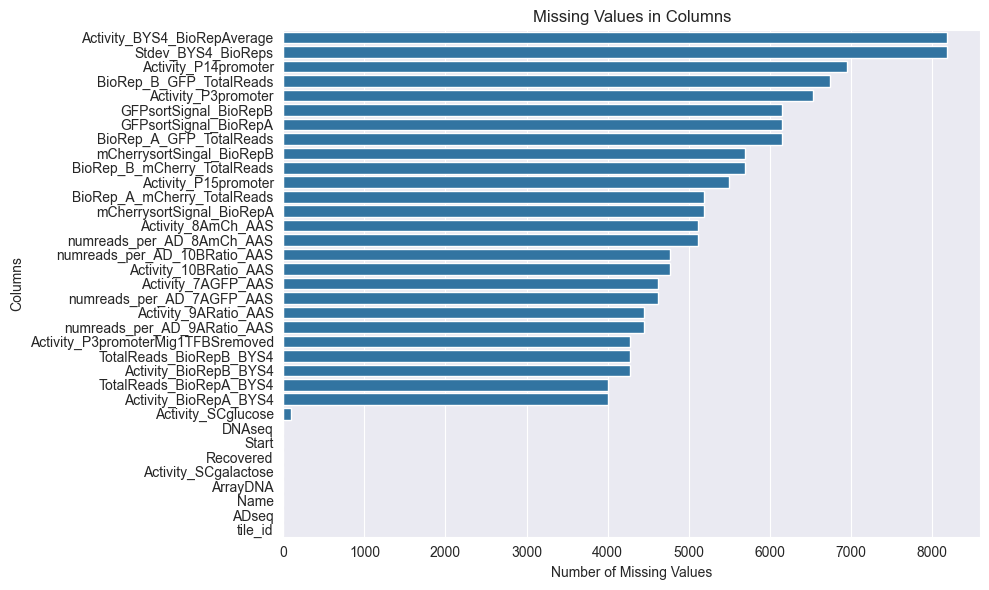

In [5]:
# Bar chart for missing values horizontally
missing_values = data.isnull().sum()
#missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.values, y=missing_values.index, orient="h")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Values in Columns")
plt.tight_layout()
#plt.savefig("GCN4_missing_values.png")
plt.show()

There are quite a lot of zeroes but here we recall that the doc explicitly mentions that the tile with `NaN` activities really means that they were not measured at all. So, intuitively, it dos not make sense to treat these values as  zero-activity values since this would mislead our model into thinking that these tiles are just functionally silent.

As per the final project warmup, it will be good to only consider the rows with a higher sequencing reads since those with very low sequencing reads can be introduce noise when we begin modelling. To this end, we set a introduce a new hyperparameter `read_threshold` that will allow us to filter the dataset for rows with reads greater than or equal to the arbitrarily specified `read_threshold`

In [6]:
read_threshold = 1000 # threshold for read count

df_filtered = data[(data['TotalReads_BioRepA_BYS4'] >= read_threshold) & (data['TotalReads_BioRepB_BYS4'] >= read_threshold)]
print(f"Number of rows before filtering: {num_rows}")
print(f"Number of rows removed: {num_rows - df_filtered.shape[0]}")
print(f"Number of rows after filtering: {df_filtered.shape[0]}")

Number of rows before filtering: 19038
Number of rows removed: 9985
Number of rows after filtering: 9053


For a baseline model, we will use `Activity_SCglucose` as a baseline activity measurement since I believe the project doc mentioned it is the most well-characterized condition in the dataset. Since the project doc says that zeroes represent unmeasured quantities, I will drop these rows to prevent additional noise in our data

In [7]:
activity_col = "Activity_SCglucose"
df_filtered = df_filtered[df_filtered[activity_col] > 0]

print(f"Number of rows after filtering for non-zero {activity_col}: {df_filtered.shape[0]}")

Number of rows after filtering for non-zero Activity_SCglucose: 9053


I'll also quickly check if there are any duplicates in our data that may bias model metrics later on

In [8]:
# Check for duplicates
duplicates = df_filtered.duplicated(subset=["tile_id"], keep=False)
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [9]:
df_with_seq = df_filtered.copy()

## Feature Engineering
Section to add new features inferred from existing columns like net charge

In [10]:
# FEATURES

# variables I need globally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [11]:
# Apply features to the filtered DataFrame
df_filtered = add_sequence_features(df_filtered)
df_filtered.iloc[:, 35:]

,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,...,DE_WF,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL
1,6,-34.0,40,2,0,2,0,0,4,1,...,0,0,0,0,0,0,0,0,1,0
7,1,-24.2,40,3,1,2,1,1,3,3,...,0,0,0,0,0,0,0,0,0,0
8,2,-36.7,40,2,0,3,0,0,2,1,...,0,0,1,0,0,0,0,0,2,0
12,-4,-13.8,40,6,0,4,2,4,3,0,...,1,3,0,1,0,0,1,0,1,0
18,6,-24.4,40,5,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19021,-1,-33.9,40,2,0,3,1,4,0,4,...,1,0,0,1,0,0,1,0,1,0
19030,-6,19.9,40,3,1,6,0,3,1,0,...,0,1,0,1,0,0,0,0,0,0
19033,-7,-42.3,40,1,0,5,3,2,2,1,...,0,1,1,1,0,0,0,0,1,0
19036,2,27.8,40,5,2,1,0,2,3,2,...,0,0,0,0,0,0,0,0,1,0


## Feature Selection
FOr now I'm gonna use all of them

In [12]:
X = df_filtered.iloc[:, 35:]
y = df_filtered[activity_col]


# now i structure the final prep data
df = pd.concat([X, y], axis=1)

assert df.isna().sum().sum() == 0, "Features contain NaNs"

# quick sanity check for missing values
print("Missing values in final data:")
print(df.isnull().sum())

Missing values in final data:
NetCharge             0
Hydrophobicity        0
Length                0
AA_A                  0
AA_C                  0
AA_D                  0
AA_E                  0
AA_F                  0
AA_G                  0
AA_H                  0
AA_I                  0
AA_K                  0
AA_L                  0
AA_M                  0
AA_N                  0
AA_P                  0
AA_Q                  0
AA_R                  0
AA_S                  0
AA_T                  0
AA_V                  0
AA_W                  0
AA_Y                  0
W..LF                 0
WFYL_WFYL             0
WFL_WFL               0
DE_WFY                0
DE_WF                 0
DE_L                  0
DE_x_WFY              0
DE_xx_WFY             0
FF                    0
F_F                   0
F__F                  0
FY_5x_FY              0
SP                    0
WFYL_3x_WFYL          0
Activity_SCglucose    0
dtype: int64


In [13]:
df.head()

,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
1,6,-34.0,40,2,0,2,0,0,4,1,...,0,0,0,0,0,0,0,1,0,21968.05843
7,1,-24.2,40,3,1,2,1,1,3,3,...,0,0,0,0,0,0,0,0,0,70876.84864
8,2,-36.7,40,2,0,3,0,0,2,1,...,0,1,0,0,0,0,0,2,0,16850.74599
12,-4,-13.8,40,6,0,4,2,4,3,0,...,3,0,1,0,0,1,0,1,0,226681.83670
18,6,-24.4,40,5,0,0,1,2,0,1,...,0,0,0,0,0,0,0,1,0,33491.53797


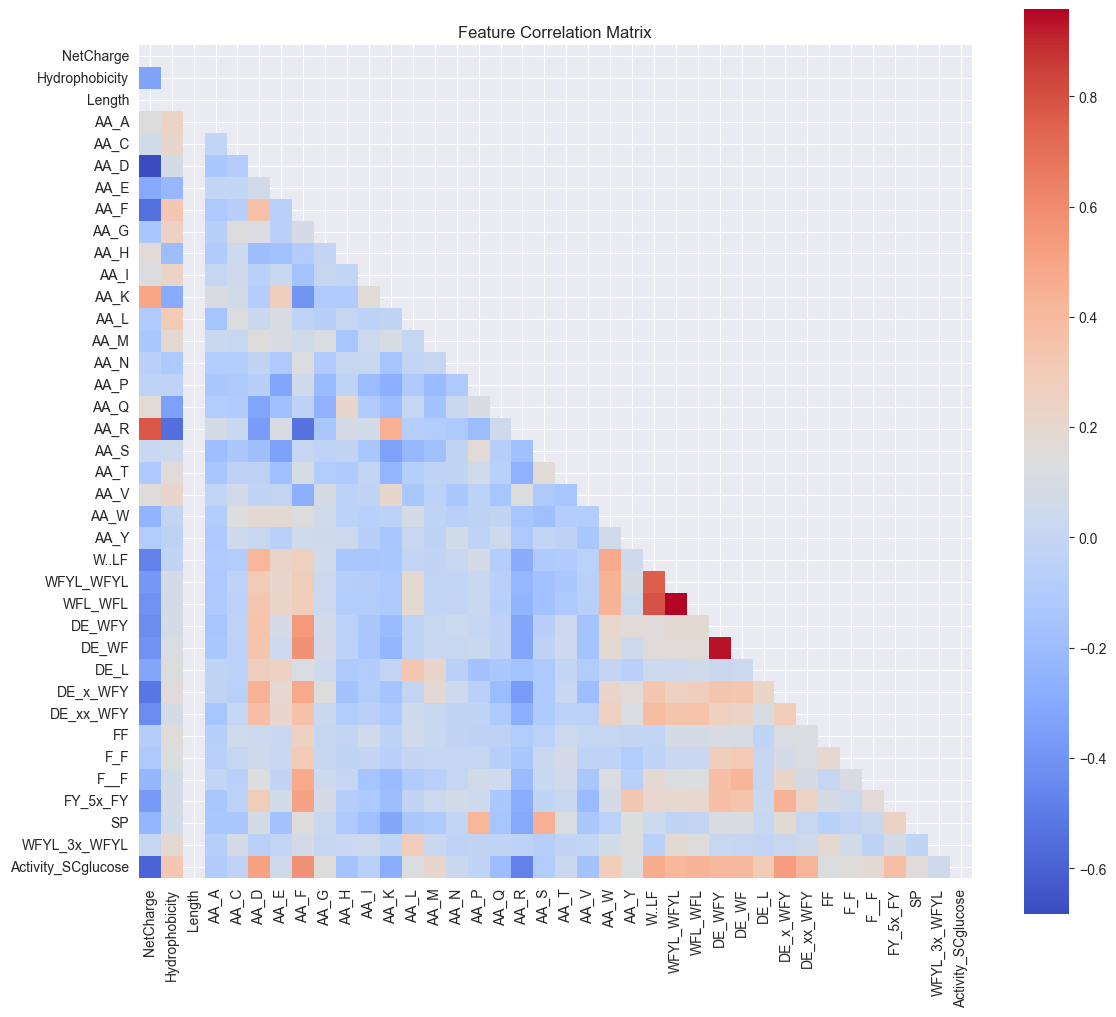

In [14]:
# Check correlation matrix
plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
#plt.savefig("GCN4_correlation_matrix.png")
plt.show()

In [15]:
# Get top 10 positive and negative correlations with the target variable
corr_target = df.corr()[activity_col].sort_values(ascending=False)
top_10_positive = corr_target.head(10)
top_10_negative = corr_target.tail(10)
print("Top 10 positive correlations with target:")
print(top_10_positive)

print("="*50)

print("Top 10 negative correlations with target:")
print(top_10_negative)

Top 10 positive correlations with target:
Activity_SCglucose    1.000000
AA_F                  0.578342
DE_x_WFY              0.529104
AA_D                  0.513607
W..LF                 0.465606
WFL_WFL               0.431691
DE_xx_WFY             0.422044
WFYL_WFYL             0.408972
DE_WFY                0.408531
DE_WF                 0.401886
Name: Activity_SCglucose, dtype: float64
Top 10 negative correlations with target:
AA_I        -0.062509
AA_S        -0.088594
AA_A        -0.101470
AA_H        -0.158249
AA_V        -0.164977
AA_Q        -0.198470
AA_K        -0.281673
AA_R        -0.473222
NetCharge   -0.588060
Length            NaN
Name: Activity_SCglucose, dtype: float64


## Baseline Model Development

In typical ML fashion, we begin by splitting our data into a train and test set. Also, since the target values are much higher than our engineered features, we will have to scale it appropriately. I'm just going to use Z-Score normalization which is implemented out of the box via sklearn's `StandardScaler` class.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cool, now that we have train and test set, we're going to build multiple baseline models, i will try lasso and ridge regression

In [17]:
ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg.fit(X_train, y_train)
ridge_reg_y_pred = ridge_reg.predict(X_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_test, ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.6201281103997196
MAE: 28987.144163384637
RMSE: 39767.08032290966
Pearson Correlation: 0.7876414833027809


In [18]:
lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg.fit(X_train, y_train)
lasso_reg_y_pred = lasso_reg.predict(X_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_test, lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.6201318526495319
MAE: 28986.773807345668
RMSE: 39766.88444277287
Pearson Correlation: 0.7876439144538867


In [19]:
grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg.fit(X_train, y_train)
grad_boost_reg_y_pred = grad_boost_reg.predict(X_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_test, grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.753700802349068
MAE: 22520.370014086355
RMSE: 32021.127989379256
Pearson Correlation: 0.8700241578562002


In [20]:
random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg.fit(X_train, y_train)
random_forest_y_pred = random_forest_reg.predict(X_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_test, random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7964616590250028
MAE: 20034.682208224433
RMSE: 29109.064143770254
Pearson Correlation: 0.8931362250804086


### Baseline Model Evaluation

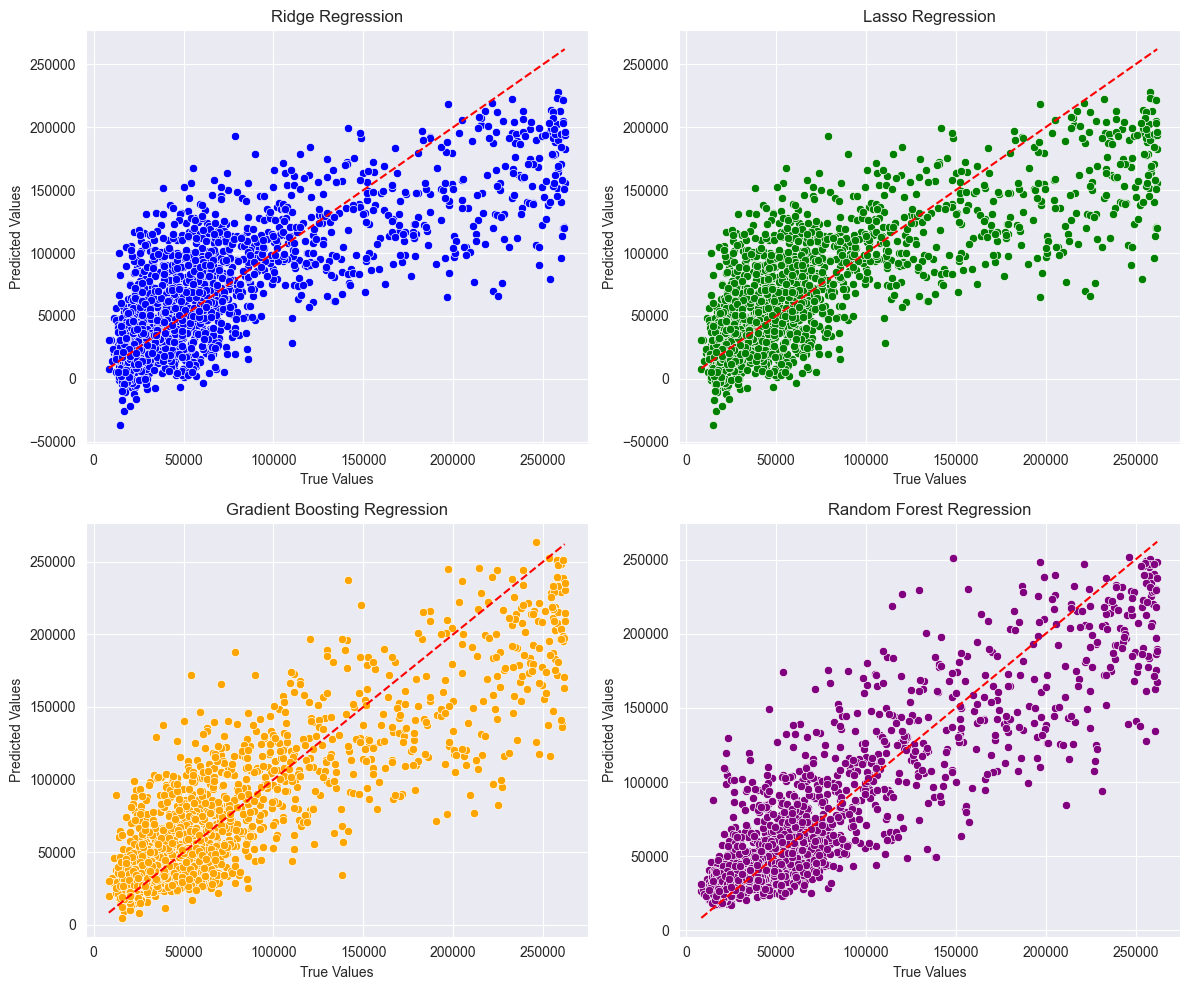

In [21]:
# Make subplots for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_test, y=ridge_reg_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_test, y=lasso_reg_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[1], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_test, y=grad_boost_reg_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Gradient Boosting Regression")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_test, y=random_forest_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[3], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [22]:
# Make df of results
results = {
    "Model": ["Ridge", "Lasso", "Gradient Boosting", "Random Forest"],
    "R^2": [
        r2_score(y_test, ridge_reg_y_pred),
        r2_score(y_test, lasso_reg_y_pred),
        r2_score(y_test, grad_boost_reg_y_pred),
        r2_score(y_test, random_forest_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_test, ridge_reg_y_pred),
        mean_absolute_error(y_test, lasso_reg_y_pred),
        mean_absolute_error(y_test, grad_boost_reg_y_pred),
        mean_absolute_error(y_test, random_forest_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_test, ridge_reg_y_pred),
        root_mean_squared_error(y_test, lasso_reg_y_pred),
        root_mean_squared_error(y_test, grad_boost_reg_y_pred),
        root_mean_squared_error(y_test, random_forest_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_test, ridge_reg_y_pred)[0],
        pearsonr(y_test, lasso_reg_y_pred)[0],
        pearsonr(y_test, grad_boost_reg_y_pred)[0],
        pearsonr(y_test, random_forest_y_pred)[0]
    ]
}
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
results_df.head()

,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest,0.796462,20034.682208,29109.064144,0.893136
1,Gradient Boosting,0.753701,22520.370014,32021.127989,0.870024
2,Lasso,0.620132,28986.773807,39766.884443,0.787644
3,Ridge,0.620128,28987.144163,39767.080323,0.787641


In [23]:
# Save the model
joblib.dump(random_forest_reg, "./models/random_forest_model.pkl")

['./models/random_forest_model.pkl']

## Feature Importances Analysis

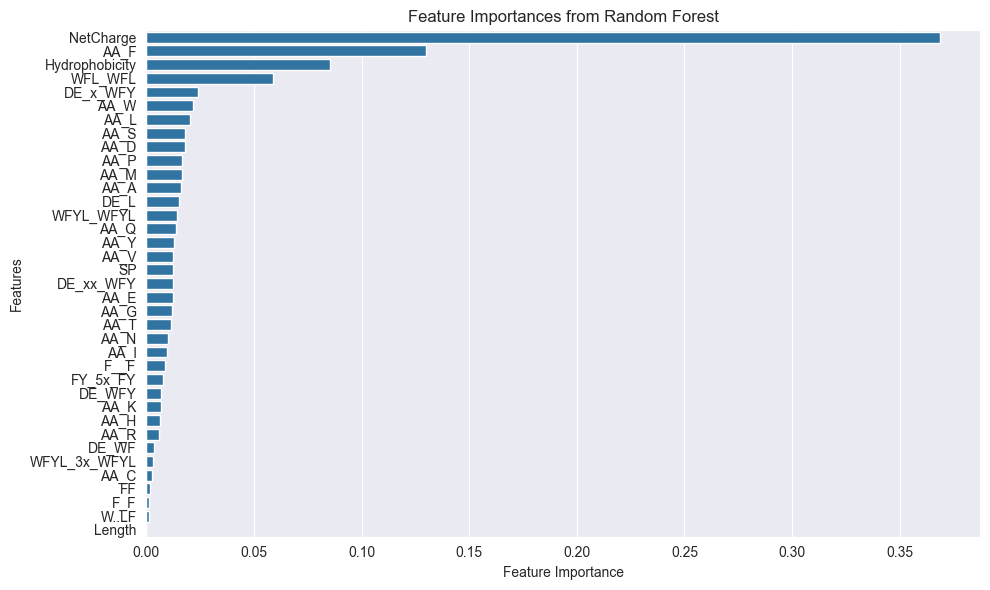

In [24]:
feature_importances = random_forest_reg.named_steps['randomforestregressor'].feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

## Protein Language Model (PLM) Features

Here I will be utilizing the Evolutionary Scale Model 2 produced by Facebook AI Research. In particular, I will be utilizing the 8M parameter version to generate feature-rich embeddings to train some baseline models. We set load the model below and run it on inference mode to generate these embeddings. To ensure this runs without any issues, please ensure you have set the `HF_TOKEN` in the .env file!

We will first augment our existing engineered features with these embeddings, and below I will perform an ablation study for further analysis on which features actually mattered

### Feature Extraction

In [25]:
# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_PLM_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_PLM_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_PLM_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

# Comment out when not needed
# save_PLM_embeddings_to_npz(df_with_seq, sequence_column="ADseq", save_path="./feature-embeddings/esm2_embeddings.npz")


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Baseline Models With PLM Embeddings

In [28]:
# Load the embeddings from the NPZ file
embeddings_data = np.load("./feature-embeddings/esm2_embedding.npz")
embeddings = embeddings_data["embeddings"]

# Check the shape of the loaded embeddings
print(f"Loaded embeddings shape: {embeddings.shape}")

Loaded embeddings shape: (9053, 320)


In [30]:
# Prep embededings into a dataframe for feature concatenation
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.columns = [f"embedding_{i}" for i in range(embeddings_df.shape[1])]
embeddings_df.head(3)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_310,embedding_311,embedding_312,embedding_313,embedding_314,embedding_315,embedding_316,embedding_317,embedding_318,embedding_319
0,-0.025192,-0.386163,0.038171,0.142583,0.045324,-0.185973,-0.089887,0.023278,-0.155760,-0.039424,...,0.242718,-0.096438,0.113960,0.213151,-0.079959,0.146884,-0.072922,0.234120,-0.032808,0.050551
1,0.014334,-0.416917,0.232792,0.121774,-0.028585,-0.204531,-0.152476,0.021117,-0.132263,-0.106221,...,0.087891,-0.152725,0.103766,0.121723,-0.077505,0.077167,-0.150012,0.081626,0.134874,0.011173
2,-0.005063,-0.397236,-0.005174,0.114196,0.172707,-0.098770,-0.020182,0.004256,-0.168792,-0.136290,...,0.192599,-0.115246,0.148075,0.255852,-0.075508,0.183582,-0.043454,0.221282,0.090849,0.028793


In [31]:
# the assert below is for me to chek for dimension mismatch
assert embeddings_df.shape[0] == df_filtered.shape[0], "Mismatch in number of rows between embeddings and original DataFrame"

# Concatenate the embeddings with the original DataFrame
X_esm = pd.concat([X.reset_index(drop=True),
                   embeddings_df.reset_index(drop=True)],
                  axis=1)
y_esm = y.copy()

print(f"X_esm shape: {X_esm.shape}")
print(f"y_esm shape: {y_esm.shape}")

X_esm shape: (9053, 357)
y_esm shape: (9053,)


In [32]:
X_esm_train, X_esm_test, y_esm_train, y_esm_test = train_test_split(X_esm, y_esm, test_size=0.2, random_state=42)

In [33]:
esm_ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
esm_ridge_reg.fit(X_esm_train, y_esm_train)
esm_ridge_reg_y_pred = esm_ridge_reg.predict(X_esm_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.7511689855278898
MAE: 24034.420049250664
RMSE: 32185.286769801744
Pearson Correlation: 0.8667569536805826


In [34]:
esm_lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
esm_lasso_reg.fit(X_esm_train, y_esm_train)
esm_lasso_reg_y_pred = esm_lasso_reg.predict(X_esm_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.7510949161147219
MAE: 24038.644276263793
RMSE: 32190.076703098766
Pearson Correlation: 0.8667134451972633


In [35]:
esm_random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
esm_random_forest_reg.fit(X_esm_train, y_esm_train)
esm_random_forest_y_pred = esm_random_forest_reg.predict(X_esm_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_esm_test, esm_random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7831166909019083
MAE: 21028.70396483801
RMSE: 30048.1814671093
Pearson Correlation: 0.8878351100156034


In [36]:
esm_grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
esm_grad_boost_reg.fit(X_esm_train, y_esm_train)
esm_grad_boost_reg_y_pred = esm_grad_boost_reg.predict(X_esm_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.7703598638819741
MAE: 21776.798479821453
RMSE: 30919.255336195565
Pearson Correlation: 0.8782237127326246


### Result Analysis: Features Augmented With PLM Embeddings

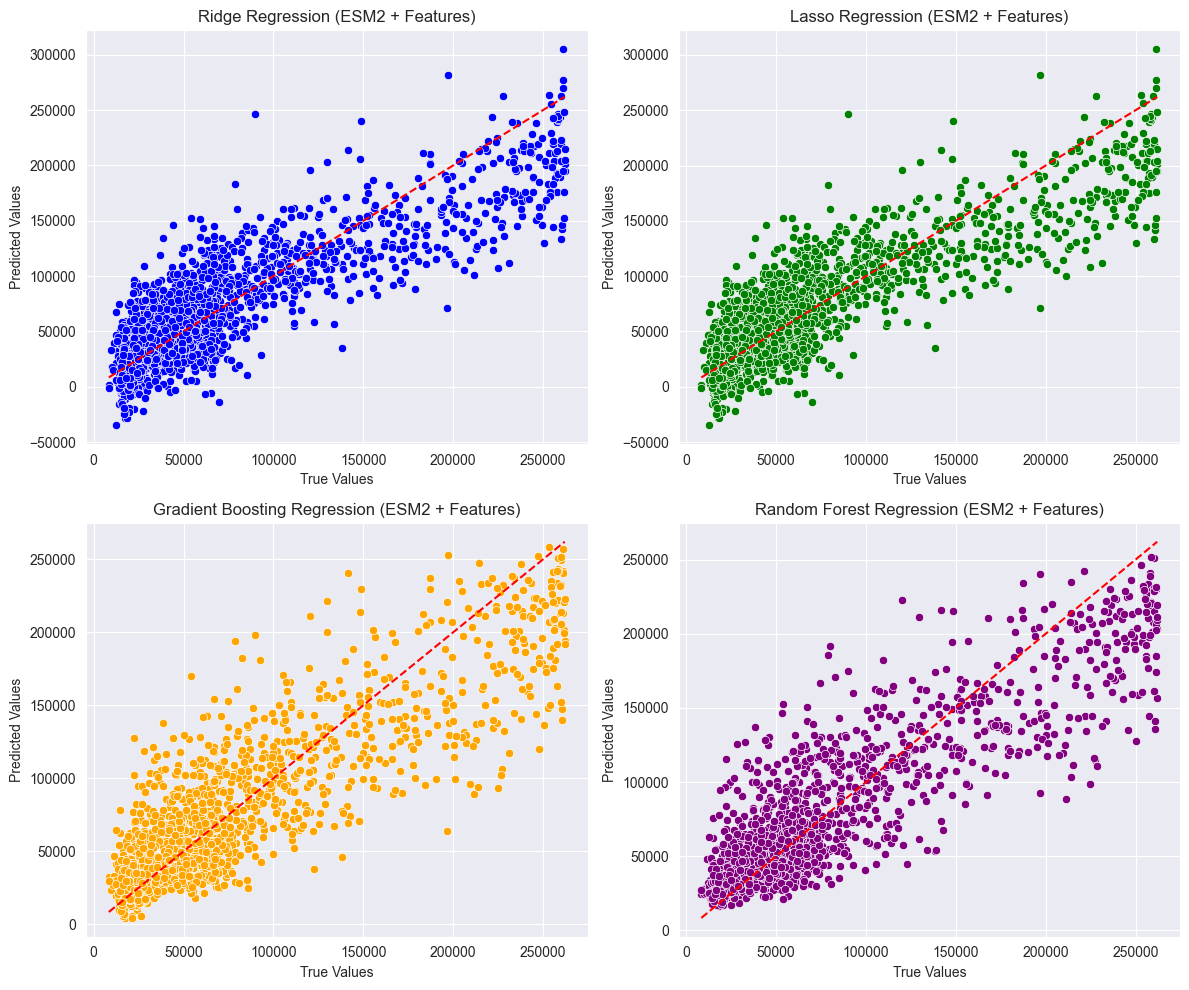

In [37]:
# Make subplots for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_esm_test, y=esm_ridge_reg_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression (ESM2 + Features)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_esm_test, y=esm_lasso_reg_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression (ESM2 + Features)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[1], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_esm_test, y=esm_grad_boost_reg_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Gradient Boosting Regression (ESM2 + Features)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_esm_test, y=esm_random_forest_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression (ESM2 + Features)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[3], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [38]:
# Make df of results
esm_results = {
    "Model": ["Ridge (ESM)", "Lasso (ESM)", "Gradient Boosting (ESM)", "Random Forest (ESM)"],
    "R^2": [
        r2_score(y_esm_test, esm_ridge_reg_y_pred),
        r2_score(y_esm_test, esm_lasso_reg_y_pred),
        r2_score(y_esm_test, esm_grad_boost_reg_y_pred),
        r2_score(y_esm_test, esm_random_forest_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_esm_test, esm_ridge_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_lasso_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_grad_boost_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_random_forest_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_esm_test, esm_ridge_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_lasso_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_grad_boost_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_random_forest_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_esm_test, esm_ridge_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_lasso_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_grad_boost_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_random_forest_y_pred)[0]
    ]
}
esm_results_df = pd.DataFrame(esm_results)
esm_results_df = esm_results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
esm_results_df.head()

,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest (ESM),0.783117,21028.703965,30048.181467,0.887835
1,Gradient Boosting (ESM),0.770360,21776.798480,30919.255336,0.878224
2,Ridge (ESM),0.751169,24034.420049,32185.286770,0.866757
3,Lasso (ESM),0.751095,24038.644276,32190.076703,0.866713


### Analyzing Model Feature Importances

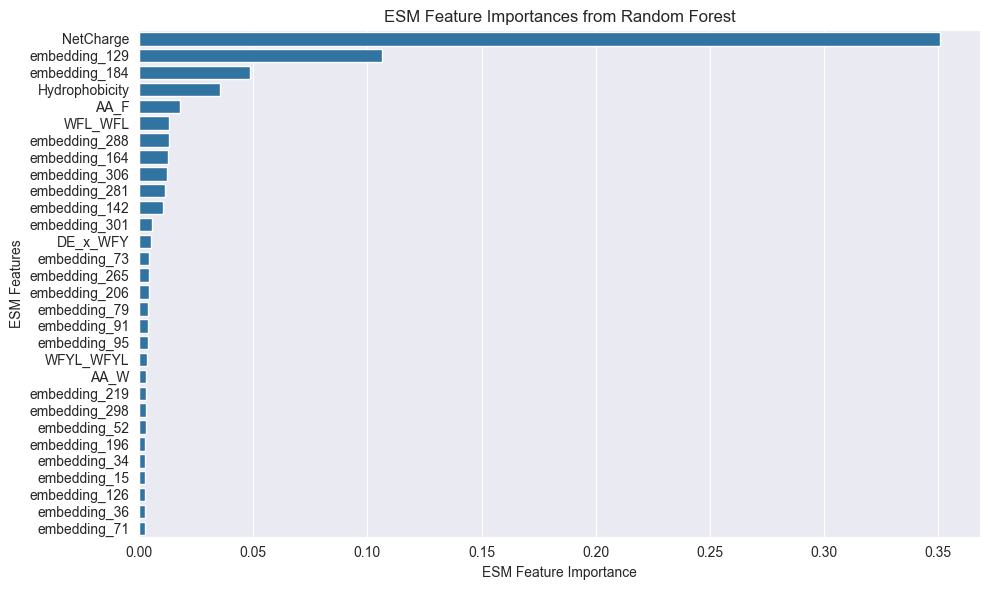

In [39]:
esm_feature_importances = esm_random_forest_reg.named_steps['randomforestregressor'].feature_importances_
esm_feature_names = X_esm.columns
esm_sorted_indices = np.argsort(esm_feature_importances)[::-1]

top_k = 30

sorted_esm_feature_importances = esm_feature_importances[esm_sorted_indices][:top_k]
sorted_esm_feature_names = esm_feature_names[esm_sorted_indices][:top_k]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_esm_feature_importances, y=sorted_esm_feature_names)
plt.xlabel("ESM Feature Importance")
plt.ylabel("ESM Features")
plt.title("ESM Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

In [40]:
# Save the best model
import joblib
joblib.dump(esm_random_forest_reg, "./models/esm_random_forest_model.pkl")

['./models/esm_random_forest_model.pkl']

### Model Baseline With ONLY ESM Embeddings

In [41]:
X_only_embeddings = embeddings_df.copy()
y_only_embeddings = y.copy()

In [42]:
X_only_embeddings_train, X_only_embeddings_test, y_only_embeddings_train, y_only_embeddings_test = train_test_split(X_only_embeddings, y_only_embeddings, test_size=0.2, random_state=42)

In [43]:
# Ridge Regression
ridge_reg_embeddings = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
ridge_reg_embeddings_y_pred = ridge_reg_embeddings.predict(X_only_embeddings_test)
print("Ridge Regression Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, ridge_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, ridge_reg_embeddings_y_pred)[0]}")

Ridge Regression Results (Only ESM2):
R^2: 0.7352434301294645
MAE: 24905.8110869024
RMSE: 33199.26743994393
Pearson Correlation: 0.8575280967166445


In [44]:
# Lasso
lasso_reg_embeddings = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
lasso_reg_embeddings_y_pred = lasso_reg_embeddings.predict(X_only_embeddings_test)
print("Lasso Regression Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, lasso_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, lasso_reg_embeddings_y_pred)[0]}")

Lasso Regression Results (Only ESM2):
R^2: 0.7350511970191826
MAE: 24916.38179154141
RMSE: 33211.317831007436
Pearson Correlation: 0.85741734106234


In [45]:
# Gradient Boosting
grad_boost_reg_embeddings = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
grad_boost_reg_embeddings_y_pred = grad_boost_reg_embeddings.predict(X_only_embeddings_test)
print("Gradient Boosting Regressor Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)[0]}")

Gradient Boosting Regressor Results (Only ESM2):
R^2: 0.7441358297140092
MAE: 22890.408201243095
RMSE: 32636.972459616703
Pearson Correlation: 0.8633379472200106


In [46]:
# Random Forest Regression
random_forest_reg_embeddings = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
random_forest_reg_embeddings_y_pred = random_forest_reg_embeddings.predict(X_only_embeddings_test)
print("Random Forest Regressor Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)[0]}")

Random Forest Regressor Results (Only ESM2):
R^2: 0.7626615109759346
MAE: 21835.07263069204
RMSE: 31433.24478052181
Pearson Correlation: 0.8780993394515852


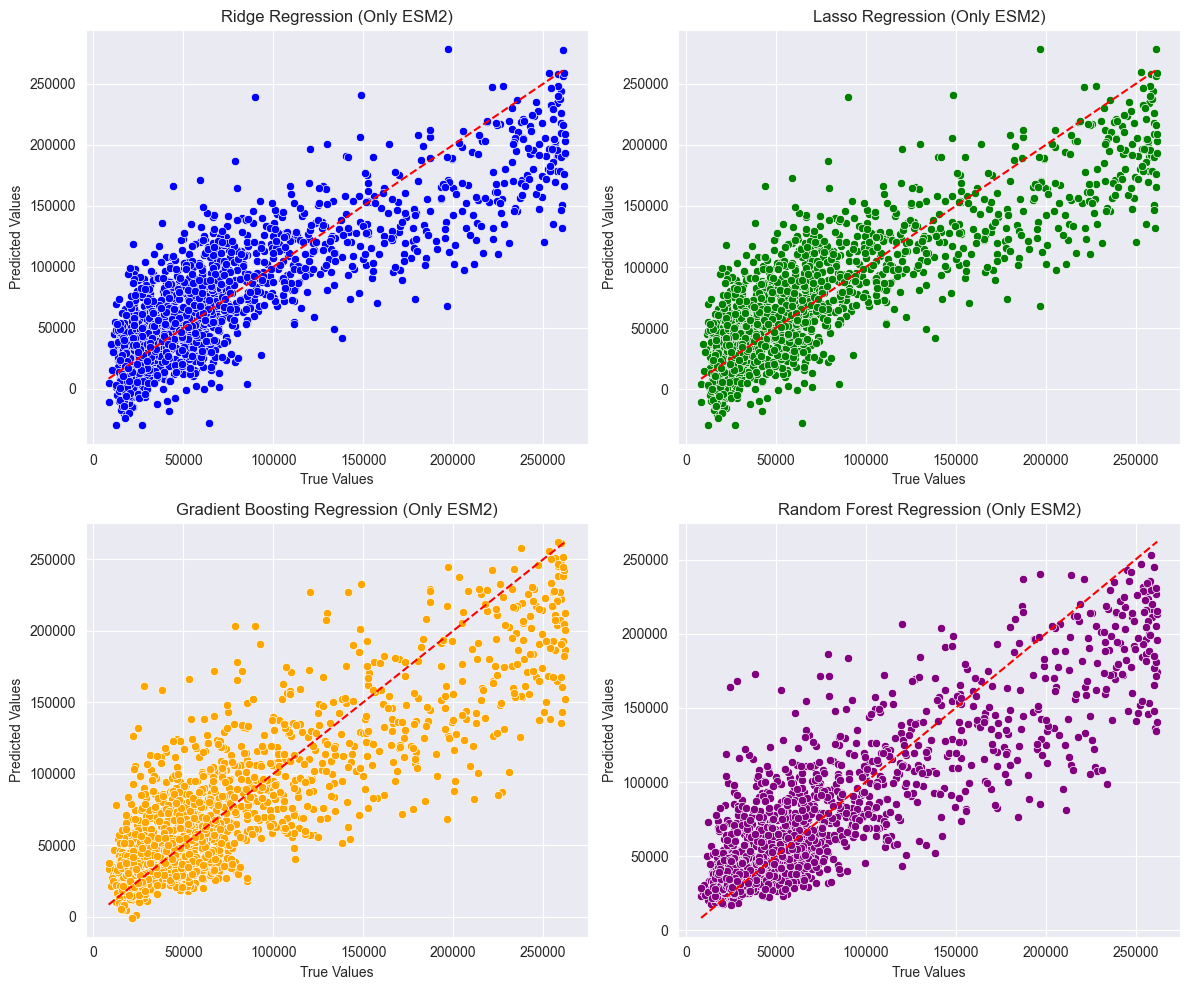

In [47]:
# subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_only_embeddings_test, y=ridge_reg_embeddings_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression (Only ESM2)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_only_embeddings_test, y=lasso_reg_embeddings_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression (Only ESM2)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[1], color='red', linestyle='--')

# Gradient Boosting Regression
sns.scatterplot(x=y_only_embeddings_test, y=grad_boost_reg_embeddings_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Gradient Boosting Regression (Only ESM2)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_only_embeddings_test, y=random_forest_reg_embeddings_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression (Only ESM2)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[3], color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [48]:
# Make results df
only_embeddings_results = {
    "Model": ["Ridge (Only ESM2)", "Lasso (Only ESM2)", "Gradient Boosting (Only ESM2)", "Random Forest (Only ESM2)"],
    "R^2": [
        r2_score(y_only_embeddings_test, ridge_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, lasso_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_only_embeddings_test, ridge_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, lasso_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)[0]
    ]
}
only_embeddings_results_df = pd.DataFrame(only_embeddings_results)
only_embeddings_results_df = only_embeddings_results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)
only_embeddings_results_df.head()

,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest (Only ESM2),0.762662,21835.072631,31433.244781,0.878099
1,Gradient Boosting (Only ESM2),0.744136,22890.408201,32636.972460,0.863338
2,Ridge (Only ESM2),0.735243,24905.811087,33199.267440,0.857528
3,Lasso (Only ESM2),0.735051,24916.381792,33211.317831,0.857417


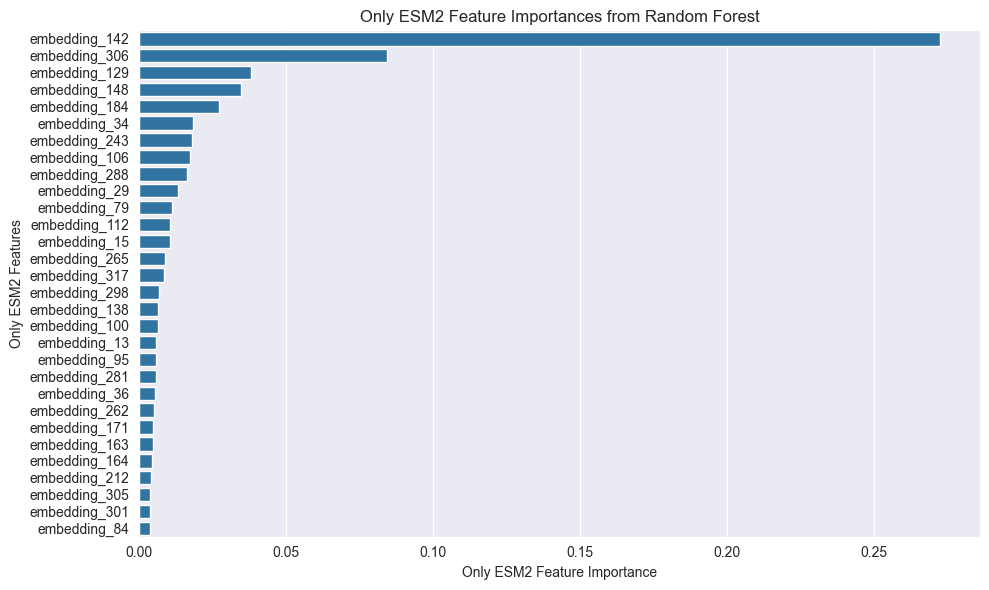

In [49]:
# feature importances
only_embeddings_feature_importances = random_forest_reg_embeddings.named_steps['randomforestregressor'].feature_importances_
only_embeddings_feature_names = X_only_embeddings.columns
only_embeddings_sorted_indices = np.argsort(only_embeddings_feature_importances)[::-1]

top_k = 30

sorted_only_embeddings_feature_importances = only_embeddings_feature_importances[only_embeddings_sorted_indices][:top_k]
sorted_only_embeddings_feature_names = only_embeddings_feature_names[only_embeddings_sorted_indices][:top_k]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_only_embeddings_feature_importances, y=sorted_only_embeddings_feature_names)
plt.xlabel("Only ESM2 Feature Importance")
plt.ylabel("Only ESM2 Features")
plt.title("Only ESM2 Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

In [50]:
# save the model
joblib.dump(random_forest_reg_embeddings, "./models/random_forest_model_only_embeddings.pkl")

['./models/random_forest_model_only_embeddings.pkl']

__________________
#### Below is the exploration of new embedding features, which is not added in our real model

## Disordered Score with Meta Predict

The relationship between AD sequence and function remains poorly understood due to the lack of conserved motifs and their intrinsic disorder. Here we use Meta Predict to get the disordered score per residue, thus generating new embeddings to train our models.

We will first augment our existing engineered features with these embeddings, and below we will show how the disordered scores themselves matter in our model.

In [54]:
def generate_disorder_scores(sequence):
    """Generate per-residue disorder scores for a given protein sequence."""
    scores = mp.predict_disorder(sequence)
    return np.array(scores)

def save_disorder_scores_to_npz(data, sequence_column, save_path):
    """Generate disorder scores for all sequences and save into a single NPZ file."""
    all_scores = []

    for sequence in tqdm(data[sequence_column], desc="Generating disorder scores"):
        scores = generate_disorder_scores(sequence)
        all_scores.append(scores)

    # Pad sequences to same length (if needed)
    max_len = max(len(s) for s in all_scores)
    padded_scores = np.array([
        np.pad(s, (0, max_len - len(s)), mode='constant', constant_values=np.nan)
        for s in all_scores
    ])

    np.savez_compressed(save_path, disorder_scores=padded_scores) # ''disorder_scores''
    print(f"Saved {len(all_scores)} disorder score arrays to {save_path}")

# Use if in need
save_disorder_scores_to_npz(df_with_seq, sequence_column="ADseq", save_path="feature-embeddings/metapredict_disorder_scores.npz")

Generating disorder scores: 100%|██████████| 9053/9053 [00:10<00:00, 831.77it/s]


Saved 9053 disorder score arrays to ./feature-embeddings/metapredict_disorder_scores.npz


In [56]:
# Load the embeddings from the NPZ file
scores_data = np.load("./feature-embeddings/metapredict_disorder_scores.npz")
scores = scores_data["disorder_scores"]

# Check the shape of the loaded embeddings
print(f"Loaded embeddings shape: {scores.shape}")

Loaded embeddings shape: (9053, 40)


In [57]:
# Prep embededings into a dataframe for feature concatenation
scores_df = pd.DataFrame(scores)
scores_df.columns = [f"score_{i}" for i in range(scores_df.shape[1])]
scores_df.head(3)

,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,...,score_30,score_31,score_32,score_33,score_34,score_35,score_36,score_37,score_38,score_39
0,0.8711,0.9277,0.9435,0.9451,0.9510,0.9483,0.9551,0.9480,0.9544,0.9407,...,0.8158,0.7972,0.7793,0.7584,0.7322,0.7112,0.6861,0.6540,0.6197,0.6016
1,0.3516,0.3583,0.3634,0.3665,0.3647,0.3662,0.3717,0.3692,0.3669,0.3549,...,0.1274,0.1227,0.1219,0.1171,0.1141,0.1043,0.0965,0.0831,0.0724,0.0742
2,0.8761,0.9112,0.9149,0.9179,0.9195,0.9153,0.9181,0.9244,0.9209,0.9183,...,0.9066,0.9118,0.9096,0.8985,0.8949,0.8761,0.8677,0.8541,0.8619,0.8771


In [59]:
# Concatenate the embeddings with the original DataFrame
X_all = pd.concat([
    X.reset_index(drop=True),
    embeddings_df.reset_index(drop=True),
    scores_df.reset_index(drop=True)
], axis=1)

y_all = y.copy()

print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")

X_all shape: (9053, 397)
y_all shape: (9053,)


In [60]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [61]:
all_ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
all_ridge_reg.fit(X_all_train, y_all_train)
all_ridge_reg_y_pred = all_ridge_reg.predict(X_all_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_all_test, all_ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_all_test, all_ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_all_test, all_ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_all_test, all_ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.7515403224337633
MAE: 24029.752535419564
RMSE: 32161.26233885723
Pearson Correlation: 0.866982774024446


In [62]:
all_lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
all_lasso_reg.fit(X_all_train, y_all_train)
all_lasso_reg_y_pred = all_lasso_reg.predict(X_all_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_all_test, all_lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_all_test, all_lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_all_test, all_lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_all_test, all_lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.7512943847145315
MAE: 24046.34114784983
RMSE: 32177.175808615128
Pearson Correlation: 0.8668407674446492


In [63]:
all_random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
all_random_forest_reg.fit(X_all_train, y_all_train)
all_random_forest_y_pred = all_random_forest_reg.predict(X_all_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_all_test, all_random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_all_test, all_random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_all_test, all_random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_all_test, all_random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7846304463220464
MAE: 20930.84979029395
RMSE: 29943.135939202413
Pearson Correlation: 0.8887444085586916


In [64]:
all_grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
all_grad_boost_reg.fit(X_all_train, y_all_train)
all_grad_boost_reg_y_pred = all_grad_boost_reg.predict(X_all_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_all_test, all_grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_all_test, all_grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_all_test, all_grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_all_test, all_grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.7705470776497959
MAE: 21723.724952917317
RMSE: 30906.649328732583
Pearson Correlation: 0.8783950142428363


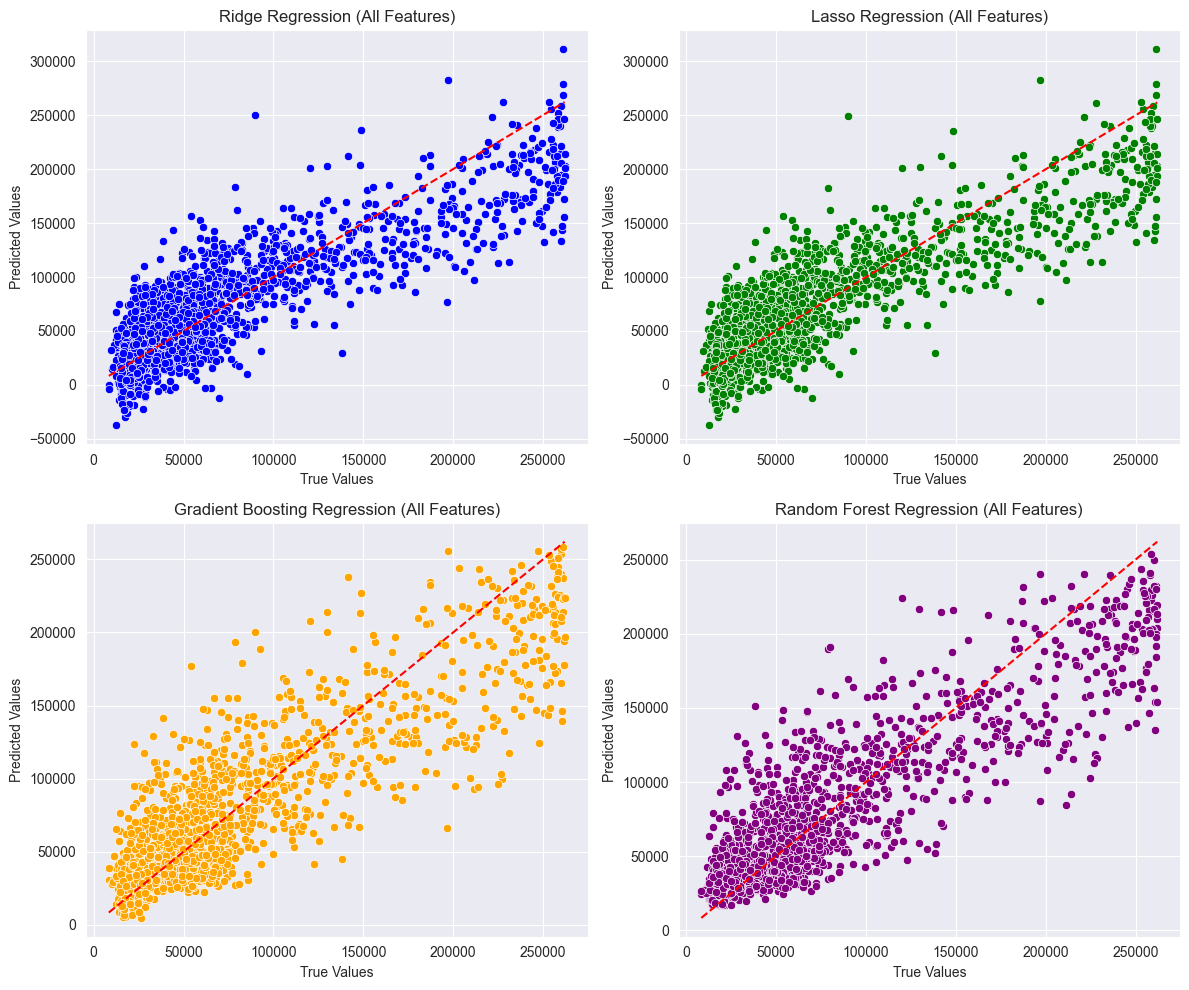

In [65]:
# Make subplots for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_all_test, y=all_ridge_reg_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression (All Features)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_all_test, y=y_all_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_all_test, y=all_lasso_reg_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression (All Features)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_all_test, y=y_all_test, ax=axes[1], color='red', linestyle='--')

# Gradient Boosting Regression
sns.scatterplot(x=y_all_test, y=all_grad_boost_reg_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Gradient Boosting Regression (All Features)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_all_test, y=y_all_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_all_test, y=all_random_forest_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression (All Features)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_all_test, y=y_all_test, ax=axes[3], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [66]:
all_results = {
    "Model": ["Ridge (All)", "Lasso (All)", "Gradient Boosting (All)", "Random Forest (All)"],
    "R^2": [
        r2_score(y_all_test, all_ridge_reg_y_pred),
        r2_score(y_all_test, all_lasso_reg_y_pred),
        r2_score(y_all_test, all_grad_boost_reg_y_pred),
        r2_score(y_all_test, all_random_forest_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_all_test, all_ridge_reg_y_pred),
        mean_absolute_error(y_all_test, all_lasso_reg_y_pred),
        mean_absolute_error(y_all_test, all_grad_boost_reg_y_pred),
        mean_absolute_error(y_all_test, all_random_forest_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_all_test, all_ridge_reg_y_pred),
        root_mean_squared_error(y_all_test, all_lasso_reg_y_pred),
        root_mean_squared_error(y_all_test, all_grad_boost_reg_y_pred),
        root_mean_squared_error(y_all_test, all_random_forest_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_all_test, all_ridge_reg_y_pred)[0],
        pearsonr(y_all_test, all_lasso_reg_y_pred)[0],
        pearsonr(y_all_test, all_grad_boost_reg_y_pred)[0],
        pearsonr(y_all_test, all_random_forest_y_pred)[0]
    ]
}
all_results_df = pd.DataFrame(all_results)
all_results_df = all_results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)
all_results_df.head()


,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest (All),0.784630,20930.849790,29943.135939,0.888744
1,Gradient Boosting (All),0.770547,21723.724953,30906.649329,0.878395
2,Ridge (All),0.751540,24029.752535,32161.262339,0.866983
3,Lasso (All),0.751294,24046.341148,32177.175809,0.866841


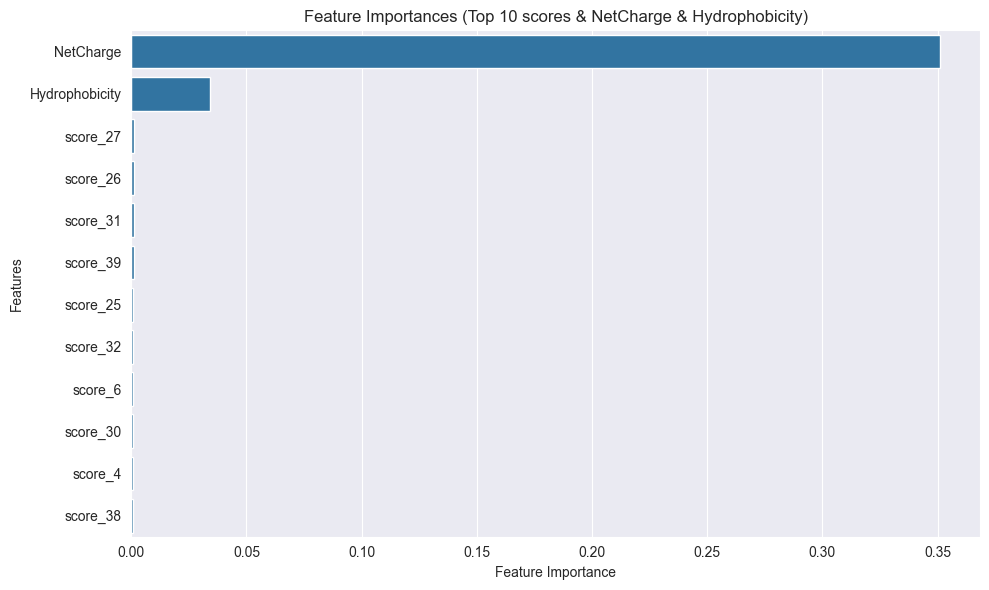

In [87]:
all_feature_importances = all_random_forest_reg.named_steps['randomforestregressor'].feature_importances_
score_columns = [col for col in X_all.columns if col.startswith('score')]

score_feature_importances = all_feature_importances[X_all.columns.isin(score_columns)]

sorted_score_indices = np.argsort(score_feature_importances)[::-1]
top_10_score_importances = score_feature_importances[sorted_score_indices][:10]
top_10_score_features = np.array(score_columns)[sorted_score_indices][:10]

additional_features = ['NetCharge', 'Hydrophobicity']
additional_importances = all_feature_importances[X_all.columns.isin(additional_features)]

combined_importances = np.concatenate([top_10_score_importances, additional_importances])
combined_features = np.concatenate([top_10_score_features, additional_features])

sorted_indices = np.argsort(combined_importances)[::-1]
sorted_combined_importances = combined_importances[sorted_indices]
sorted_combined_features = combined_features[sorted_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_combined_importances, y=sorted_combined_features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances (Top 10 scores & NetCharge & Hydrophobicity)")
plt.tight_layout()
plt.show()